# Experimento 2 - Variação entre Perfis

**Objetivo**: Verificar se a mesma pergunta gera respostas significativamente diferentes quando o perfil do usuário varia.

**Metodologia**:
* Escolher 3 perfis de usuário,
* Escolher 10 perguntas,
* Para cada pergunda, gerar uma resposta para cada perfil.
* Aplicar métricas de similaridade semântica (BERTScore, Similaridade Cosseno, etc) entre as respostas para uma mesma pergunta.

In [3]:
import json
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import edit_distance
from bert_score import score as bert_score
import numpy as np

In [2]:
# Carregar arquivo JSON com respostas dos três perfis
with open("/Users/gustavolgcr/doutorado/implementacoes/experiments/src/data/questions_and_answers_experiment_2.json", "r", encoding="utf-8") as f:
    dados = json.load(f)

df = pd.DataFrame(dados)
df.head()

,pergunta,resposta_torcedor,resposta_tecnico,resposta_narrador
0,Quais jogadores mais se destacaram no jogo con...,No jogo contra o Ceará no dia 1º de abril de 2...,"No jogo contra o Ceará, realizado em 1º de abr...","No jogo contra o Ceará, realizado em 1º de abr..."
1,O que os dados mostram sobre o desempenho do t...,"No segundo tempo do jogo contra o Ceará, reali...","No segundo tempo do jogo contra o Ceará, reali...","No segundo tempo do jogo contra o Ceará, reali..."
2,Qual jogador teve o maior impacto físico duran...,O jogador que se destacou com o maior impacto ...,O jogador que teve o maior impacto físico dura...,Durante o jogo contra o Ceará no dia 1º de abr...
3,Como foi o desempenho geral da equipe na parti...,Na emocionante partida contra o Ceará no dia 1...,Na partida contra o Ceará no dia 1º de abril d...,Na partida contra o Ceará no dia 1º de abril d...
4,Quem foram os jogadores mais decisivos durante...,"Na emocionante partida contra o Ceará, os joga...","Na partida contra o Ceará, os jogadores que se...","Durante a partida contra o Ceará, os jogadores..."


In [39]:
def cosine_sim(text1, text2):
    vect = TfidfVectorizer().fit([text1, text2])
    tfidf = vect.transform([text1, text2])
    sim = cosine_similarity(tfidf[0], tfidf[1])[0][0]
    return round(sim, 4)

def normalized_edit_distance(t1, t2):
    dist = edit_distance(t1, t2)
    return round(dist / max(len(t1), len(t2)), 4)

def get_all_metrics(t1, t2):
    P, R, F1 = bert_score([t1], [t2], lang="pt", verbose=False)
    return {
        "BERTScore": round(F1[0].item(), 4),
        "CosineSim": cosine_sim(t1, t2),
        "EditDist": normalized_edit_distance(t1, t2),
    }

**Similaridade Cosseno**: mede a similaridade semântica entre os dois textos com base no conteúdo de palavras.
* Varia de 0 (totalmente diferentes) a 1 (idênticos em termos de conteúdo de palavras).
* Exemplo: "o jogador foi bem" vs "o atleta se destacou" pode dar algo como 0.6.

**Edit Distance**: mede o número de operações (inserção, deleção, substituição) necessárias para transformar um texto no outro.
* Valor baixo → textos semelhantes; Valor alto → textos muito diferentes.
* Gira em torno de 0 a 1, com 0 indicando textos idênticos.

**BERTScore**: usa embeddings de um modelo de linguagem (como BERT ou RoBERTa) para medir similaridade semântica profunda entre os textos.
* Escala de 0 a 1, sendo 1 perfeitamente equivalente.

In [40]:
resultados = []

for item in dados:
    pergunta = item["pergunta"]
    pares = [
        ("Torcedor vs Técnico", item["resposta_torcedor"], item["resposta_tecnico"]),
        ("Torcedor vs Narrador", item["resposta_torcedor"], item["resposta_narrador"]),
        ("Técnico vs Narrador", item["resposta_tecnico"], item["resposta_narrador"]),
    ]
    
    for par_nome, t1, t2 in pares:
        metrics = get_all_metrics(t1, t2)
        metrics["pergunta"] = pergunta
        metrics["comparacao"] = par_nome
        resultados.append(metrics)

df_resultados = pd.DataFrame(resultados)
df_resultados.head()

,BERTScore,CosineSim,EditDist,pergunta,comparacao
0,0.9563,0.9795,0.1510,Quais jogadores mais se destacaram no jogo con...,Torcedor vs Técnico
1,0.6491,0.2698,0.7454,Quais jogadores mais se destacaram no jogo con...,Torcedor vs Narrador
2,0.6773,0.2764,0.7401,Quais jogadores mais se destacaram no jogo con...,Técnico vs Narrador
3,0.8107,0.6745,0.6418,O que os dados mostram sobre o desempenho do t...,Torcedor vs Técnico
4,0.8129,0.6232,0.6135,O que os dados mostram sobre o desempenho do t...,Torcedor vs Narrador


In [7]:
df_resultados.groupby("comparacao")[["BERTScore", "CosineSim", "EditDist"]].agg(["mean", "std"]).round(4)

BERTScore         CosineSim         EditDist        
                          mean     std      mean     std     mean     std
comparacao                                                               
Torcedor vs Narrador    0.8816  0.0304    0.5596  0.1516   0.6221  0.0866
Torcedor vs Técnico     0.8878  0.0305    0.5887  0.1859   0.6037  0.1752
Técnico vs Narrador     0.8914  0.0372    0.6098  0.1558   0.5750  0.1330

Embora as análises quantitativas (BERTScore, Cosine Similarity, Edit Distance) apontem para variações entre as respostas dos diferentes perfis, os valores médios das métricas indicam que tais variações são modestas. Isso sugere que o modelo gera uma estrutura de resposta relativamente comum, ajustando elementos como vocabulário, tom ou ênfase, mas sem grandes modificações semânticas ou estruturais. Esse resultado levanta a hipótese de que, em domínios com dados factuais consistentes entre perfis, a personalização pode ocorrer mais em aspectos superficiais (estilo, apresentação) do que no conteúdo central. Tal observação reforça a necessidade de mecanismos mais robustos para controle de estilo e foco no módulo de personalização.

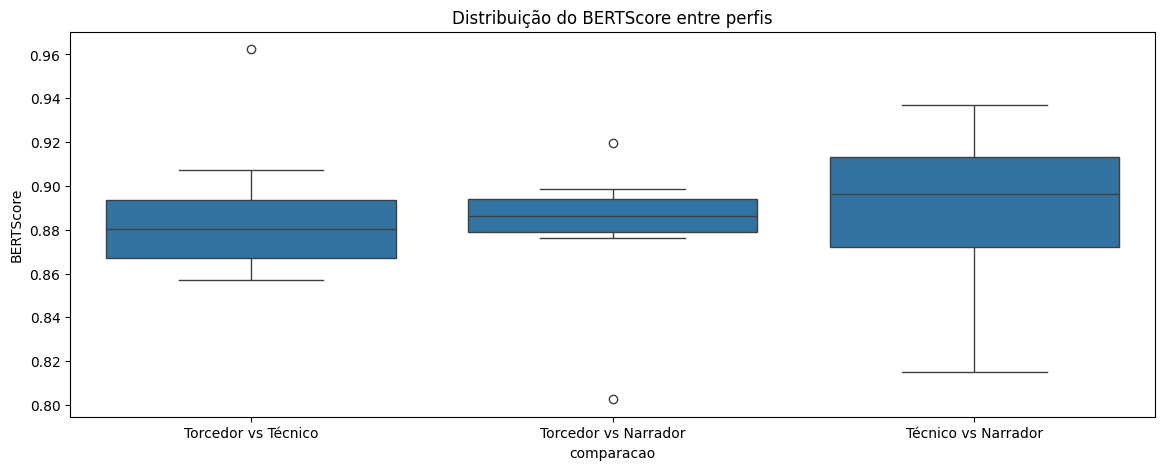

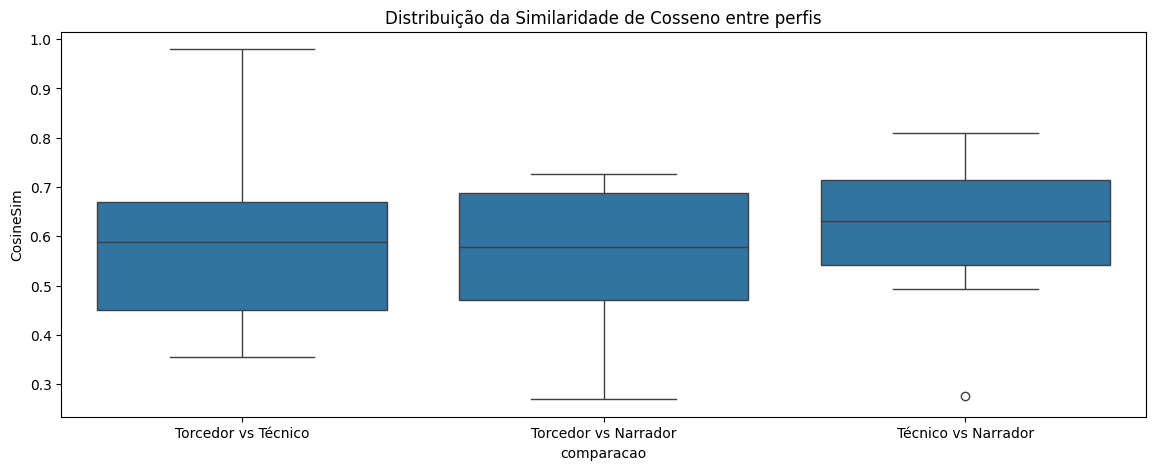

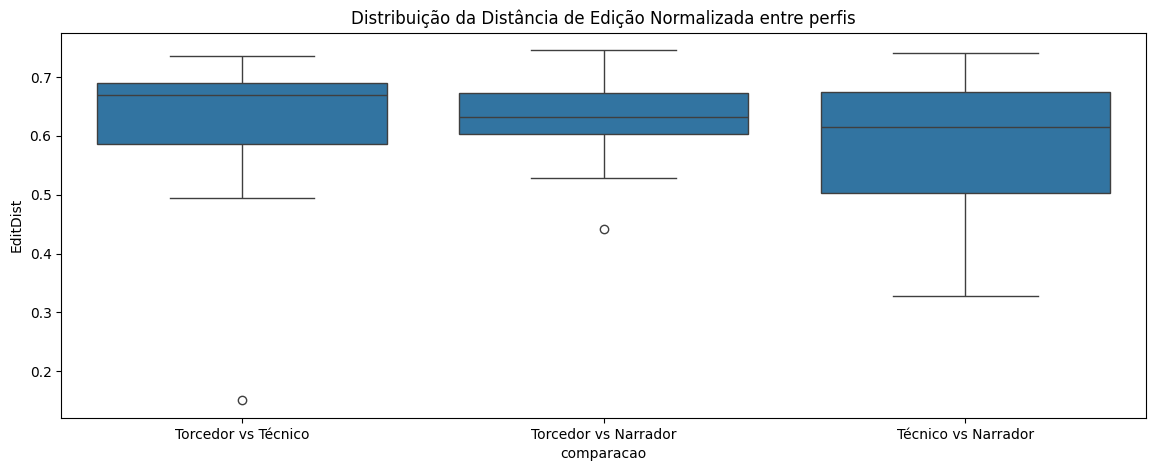

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
sns.boxplot(data=df_resultados, x="comparacao", y="BERTScore")
plt.title("Distribuição do BERTScore entre perfis")
plt.show()

plt.figure(figsize=(14, 5))
sns.boxplot(data=df_resultados, x="comparacao", y="CosineSim")
plt.title("Distribuição da Similaridade de Cosseno entre perfis")
plt.show()

plt.figure(figsize=(14, 5))
sns.boxplot(data=df_resultados, x="comparacao", y="EditDist")
plt.title("Distribuição da Distância de Edição Normalizada entre perfis")
plt.show()

Clusterização semântica

In [24]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Expandir para um DataFrame longo
respostas_longas = []
df_respostas = df

for _, row in df_respostas.iterrows():
    for perfil in ["torcedor", "tecnico", "narrador"]:
        respostas_longas.append({
            "pergunta": row["pergunta"],
            "perfil": perfil.capitalize(),
            "resposta": row[f"resposta_{perfil}"]
        })

df_embed = pd.DataFrame(respostas_longas)
df_embed.head()

,pergunta,perfil,resposta
0,Quais jogadores mais se destacaram no jogo con...,Torcedor,No jogo contra o Ceará no dia 1º de abril de 2...
1,Quais jogadores mais se destacaram no jogo con...,Tecnico,"No jogo contra o Ceará, realizado em 1º de abr..."
2,Quais jogadores mais se destacaram no jogo con...,Narrador,"No jogo contra o Ceará, realizado em 1º de abr..."
3,O que os dados mostram sobre o desempenho do t...,Torcedor,"No segundo tempo do jogo contra o Ceará, reali..."
4,O que os dados mostram sobre o desempenho do t...,Tecnico,"No segundo tempo do jogo contra o Ceará, reali..."


Gerar embeddings com Sentence-BERT

In [26]:
# Use um modelo leve e eficiente como "all-MiniLM-L6-v2"
modelo = SentenceTransformer("all-MiniLM-L6-v2")

# Embeddings
embeddings = modelo.encode(df_embed["resposta"].tolist(), show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
reductor = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine', random_state=42)
embeddings_2d = reductor.fit_transform(embeddings)

# Anexar ao DataFrame
df_embed["x"] = embeddings_2d[:, 0]
df_embed["y"] = embeddings_2d[:, 1]

/Users/gustavolgcr/doutorado/implementacoes/experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gustavolgcr/doutorado/implementacoes/experiments/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


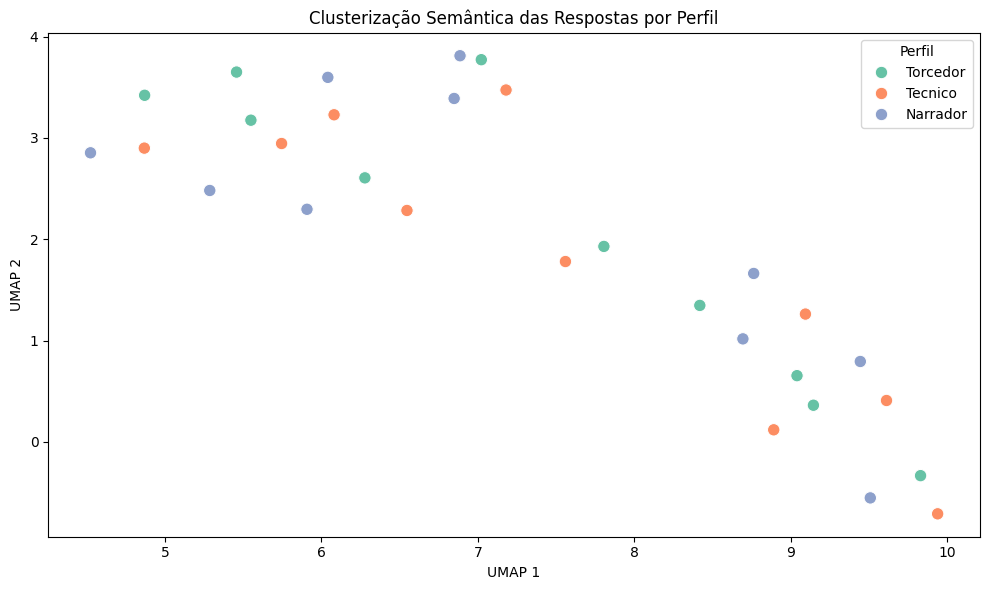

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_embed, x="x", y="y", hue="perfil", s=80, palette="Set2")
plt.title("Clusterização Semântica das Respostas por Perfil")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Perfil")
plt.tight_layout()
plt.show()

Utilizando o t-SNE

In [29]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Converter JSON para DataFrame longo
respostas_longas = []

for _, row in df_respostas.iterrows():
    for perfil in ["torcedor", "tecnico", "narrador"]:
        respostas_longas.append({
            "pergunta": row["pergunta"],
            "perfil": perfil.capitalize(),
            "resposta": row[f"resposta_{perfil}"]
        })

df_embed = pd.DataFrame(respostas_longas)

In [31]:
modelo = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = modelo.encode(df_embed["resposta"].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
tsne = TSNE(n_components=2, perplexity=15, n_iter=1000, metric='cosine', random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

df_embed["x"] = embeddings_2d[:, 0]
df_embed["y"] = embeddings_2d[:, 1]

/Users/gustavolgcr/doutorado/implementacoes/experiments/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


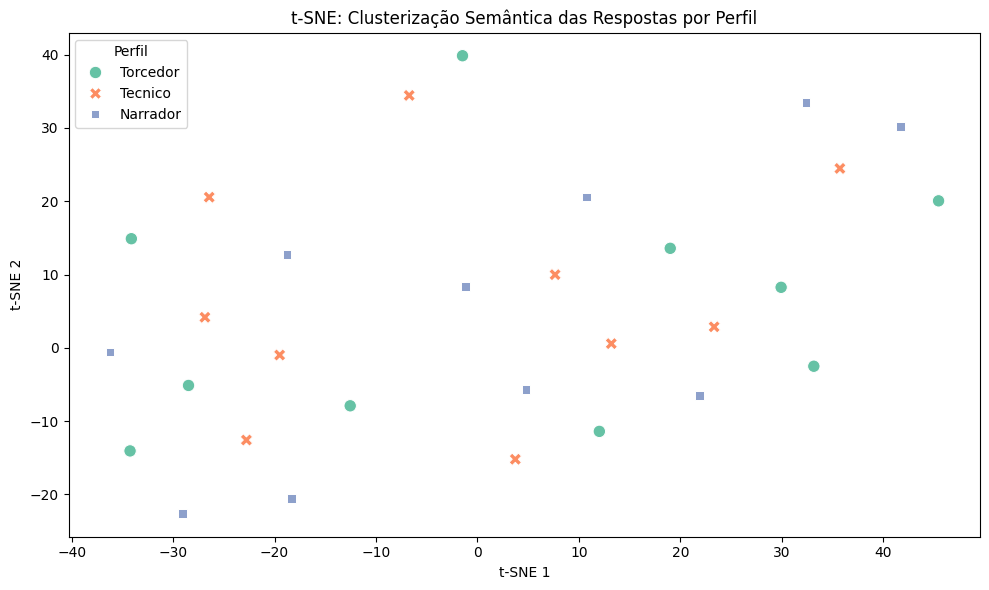

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_embed, x="x", y="y", hue="perfil", style="perfil", s=80, palette="Set2")
plt.title("t-SNE: Clusterização Semântica das Respostas por Perfil")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Perfil")
plt.tight_layout()
plt.show()


<span style="color:red">*Procurar perfis muito diferentes, como "torcedor infantil e preparador físico"*.</span>
